# Problem 1

## Task 1

Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).

This can be done with the following query:
> `select COUNT(*) from Star`
    
There are 260,562,744 stars in the database.

Write (and execute) an SQL query to count how many observations there are in u, g, r, i and z bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?

This can be done with the following query:
> `select 
COUNT(CASE WHEN u > 0 THEN u ELSE NULL END) as uCount,
COUNT(CASE WHEN g > 0 THEN g ELSE NULL END) as gCount,
COUNT(CASE WHEN r > 0 THEN r ELSE NULL END) as rCount,
COUNT(CASE WHEN i > 0 THEN i ELSE NULL END) as iCount,
COUNT(CASE WHEN z > 0 THEN z ELSE NULL END) as zCount,
AVG(CASE WHEN u > 0 THEN u ELSE NULL END) as uAv,
AVG(CASE WHEN g > 0 THEN g ELSE NULL END) as gAv,
AVG(CASE WHEN r > 0 THEN r ELSE NULL END) as rAv,
AVG(CASE WHEN i > 0 THEN i ELSE NULL END) as iAv,
AVG(CASE WHEN z > 0 THEN z ELSE NULL END) as zAv
into mydb.MyTable12 from Star`

In SDSS, missing magnitude data is recorded with a value of `-9999`.

## Task 2

Write an SQL query to select the positions ($\alpha$, also known as `ra`, and $\delta$, also know as `dec`) and the extinction-corrected (a.k.a. *dereddened*) `g` and `r`-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.tables` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).

The query I used was:

> `select ra, dec, dered_r as drr, dered_g as drg
into mydb.MyTable2 from Star
where ra > 225 and ra < 235 and dec > -2.5 and dec < 4 and dered_r > 0 and dered_g > 0`

In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import sqlite3

pathToFitsTable = '/astro/users/scw7/Dropbox/Classwork/ast597b/astr597b_wi16_hw/hw1/SpencerWallace/table.fits'
pathToSqlTable = '/astro/users/scw7/Dropbox/Classwork/ast597b/astr597b_wi16_hw/hw1/SpencerWallace/table.db'

In [6]:
t = Table.read(pathToFitsTable)
con = sqlite3.connect(pathToSqlTable)
sql_table = pd.DataFrame(np.array(t)).to_sql('table2', con, if_exists='replace')

## Task 3

In an IPython notebook, make an $ra$ vs $dec$ scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim 229$ and $\delta \sim 0$? Do know what is this object?

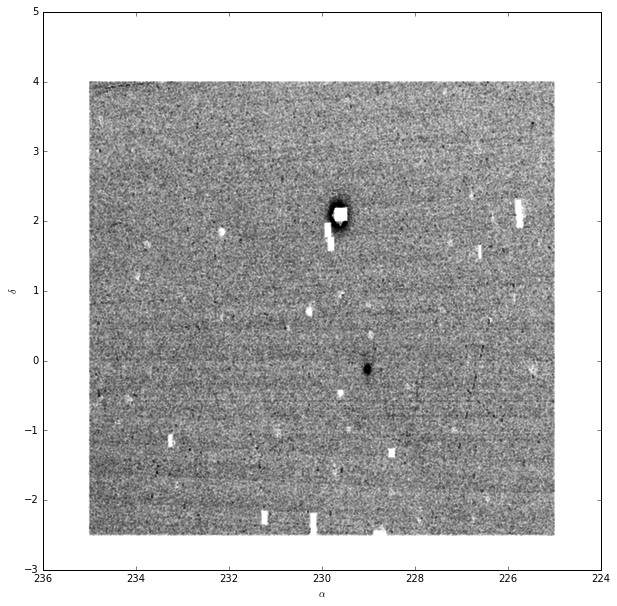

In [7]:
import matplotlib.pyplot as pl
%matplotlib inline

fig, ax = pl.subplots(figsize=(10,10))
ax.scatter(t['ra'], t['dec'], marker='.', s=0.005)

ax.invert_xaxis()
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')

There apears to be a large concentration of stars near $\alpha \sim 229$ and $\delta \sim 0$. This is a globular cluster.

## Task 4

Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but away from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

In [8]:
pythonT1 = t[(t['ra'] > 228.5) & (t['ra'] < 229.5) & (t['dec'] > -0.5) & (t['dec'] < 0.5)]
sqlT1 = pd.read_sql("""
    SELECT
        ra, dec, drg, drg
    FROM
        table2
    WHERE
        ra > 228.5 AND ra < 229.5 AND dec > -0.5 AND dec < 0.5
""", con)

pythonT2 = t[(t['ra'] > 232.5) & (t['ra'] < 233.5) & (t['dec'] > -0.5) & (t['dec'] < 0.5)]
sqlT2 = pd.read_sql("""
    SELECT
        ra, dec, drg, drg
    FROM
        table2
    WHERE
        ra > 232.5 AND ra < 233.5 AND dec > -0.5 AND dec < 0.5
""", con)

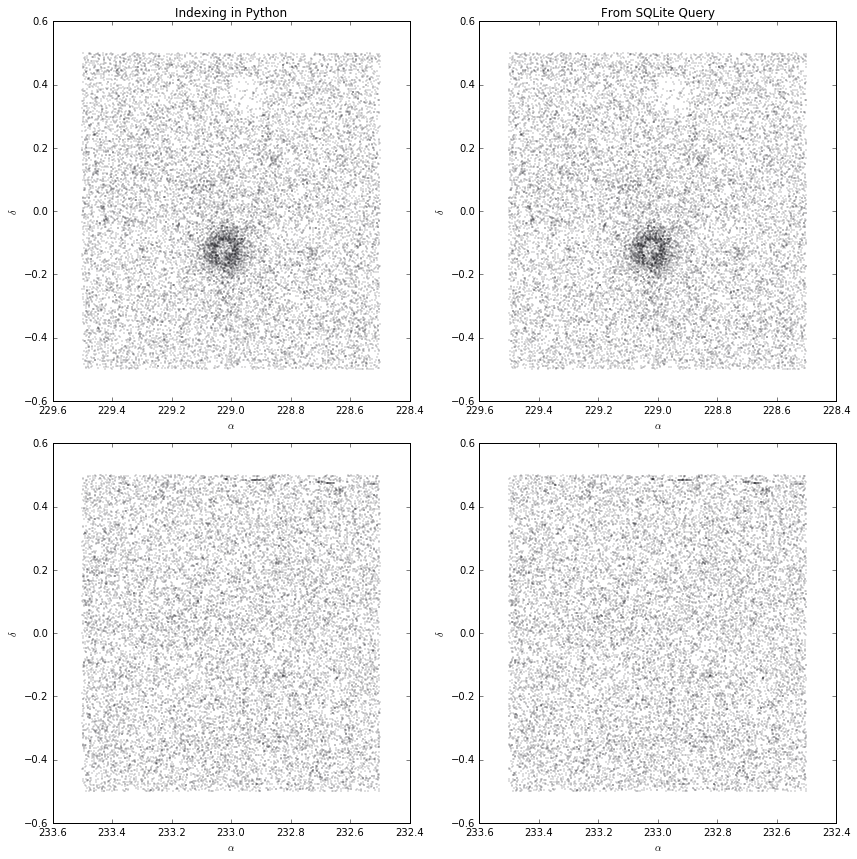

In [9]:
fig, ax = pl.subplots(figsize=(12, 12), nrows=2, ncols=2)
ax[0][0].scatter(pythonT1['ra'], pythonT1['dec'], marker='.', s=0.1)
ax[0][0].invert_xaxis()
ax[0][0].set_xlabel(r'$\alpha$')
ax[0][0].set_ylabel(r'$\delta$')
ax[0][0].set_title('Indexing in Python')

ax[0][1].scatter(sqlT1['ra'], sqlT1['dec'], marker='.', s=0.1)
ax[0][1].invert_xaxis()
ax[0][1].set_xlabel(r'$\alpha$')
ax[0][1].set_ylabel(r'$\delta$')
ax[0][1].set_title('From SQLite Query')

ax[1][0].scatter(pythonT2['ra'], pythonT2['dec'], marker='.', s=0.1)
ax[1][0].invert_xaxis()
ax[1][0].set_xlabel(r'$\alpha$')
ax[1][0].set_ylabel(r'$\delta$')

ax[1][1].scatter(sqlT2['ra'], sqlT2['dec'], marker='.', s=0.1)
ax[1][1].invert_xaxis()
ax[1][1].set_xlabel(r'$\alpha$')
ax[1][1].set_ylabel(r'$\delta$')

fig.tight_layout()

## Task 5

Make two side-by-side scatter plots of the (dereddened) $g-r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

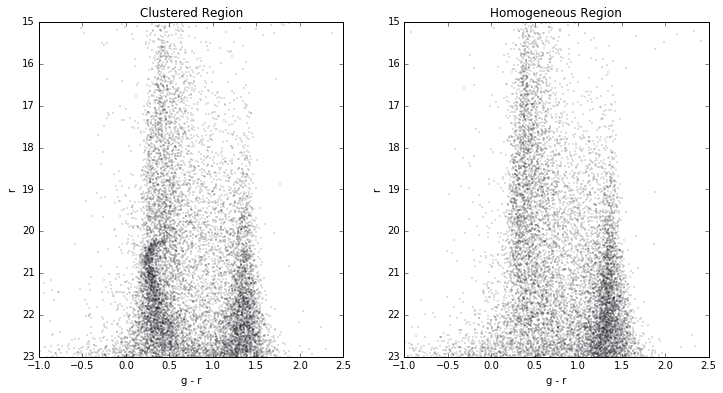

In [10]:
fig, ax = pl.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Only consider stars whose g and r magnitudes are defined
pythonT1filt = pythonT1[(pythonT1['drg'] > 0) & (pythonT1['drr'] > 0)]
pythonT2filt = pythonT2[(pythonT2['drg'] > 0) & (pythonT2['drr'] > 0)]

g = pythonT1filt['drg'] 
r = pythonT1filt['drr']
ax[0].scatter(g-r, g, marker='.', s = 0.1)
ax[0].set_xlim(-1, 2.5)
ax[0].set_ylim(15, 23)
ax[0].invert_yaxis()
ax[0].set_title('Clustered Region')
ax[0].set_xlabel('g - r')
ax[0].set_ylabel('r')

g = pythonT2filt['drg'] 
r = pythonT2filt['drr']
ax[1].scatter(g-r, g, marker='.', s = 0.1)
ax[1].set_xlim(-1, 2.5)
ax[1].set_ylim(15, 23)
ax[1].invert_yaxis()
ax[1].set_title('Homogeneous Region')
ax[1].set_xlabel('g - r')
ax[1].set_ylabel('r')

The CMD from the cluster region shows a larger concentration of blue stars. These form a 'hook' like shape on the diagram.

## Task 6

Identify a region in $g-r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that *color-magnitude* box, and plot them in $ra$ vs $dec$ scatter plot. Do you notice anything interesting?

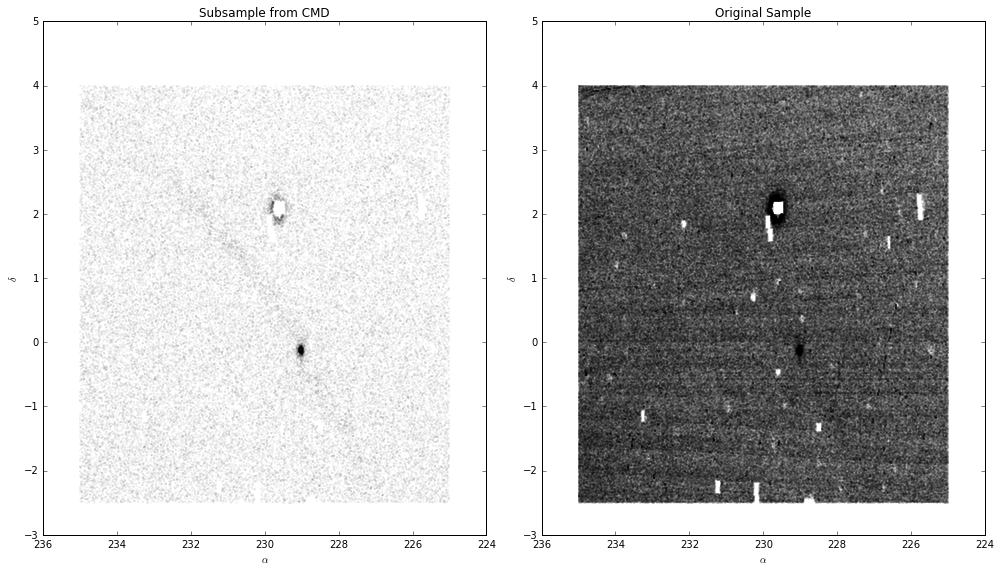

In [11]:
tFilt = t[(t['drr'] > 20) & (t['drr'] < 22) 
          & ((t['drg'] - t['drr']) > 0.0) & ((t['drg'] - t['drr']) < 0.5)]

fig, ax = pl.subplots(figsize=(14, 8), nrows=1, ncols=2)
ax[0].scatter(tFilt['ra'], tFilt['dec'], marker='.', s=0.01)
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\delta$')
ax[0].set_title('Subsample from CMD')

ax[1].scatter(t['ra'], t['dec'], marker='.', s=0.01)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\delta$')
ax[1].set_title('Original Sample')

fig.tight_layout()

The stars taken from the 'hook' part of the previous CMD appear to almost entirely come from the cluster near near $\alpha \sim 229$ and $\delta \sim 0$.

# Problem 2

Install the Large Survey Database (see Lecture #3 for instructions)

Read about the data contained in sweep files for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.

Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use lsd-import to import these files. Install the Large Survey Database (see Lecture #3 for instructions)

Use lsd-footprint to compute the footprint of the run, and plot the result.

In [12]:
import os
os.environ["LSD_CACHEDIR"] = os.environ["HOME"] + "/tempdir"
os.environ["LSD_DB"] = os.environ["HOME"] + "/lsddb"
os.environ["LSD_TEMPDIR"] = os.environ["HOME"] + "/tempdir"
os.environ["NWORKERS"] = "8"

pathToStarSweepFits = '/astro/users/scw7/Dropbox/Classwork/ast597b/astr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-*.fits'

In [13]:
! lsd-admin create table --drop-existing --schema starSweepSchema.yaml sdss_star_sweep

Table 'sdss_star_sweep' dropped.

-------- committing 20160225184229.580128 [sdss_star_sweep] ---------
[sdss_star_sweep] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.25 sec
[sdss_star_sweep] Updating neighbors: Already up to date.
[sdss_star_sweep] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.26 sec
[sdss_star_sweep] Updating stats: [0 el.]>  0.00 sec
[sdss_star_sweep] Marking tablets read-only...
----------- success 20160225184229.580128 [sdss_star_sweep] ---------

Table 'sdss_star_sweep' created.


In [14]:
! lsd-import fits sdss_star_sweep $pathToStarSweepFits

Importing from 6 pieces:
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-1-star.fits [1/6, 16.67%] + 133515/133515     133515 (0/1 min.)
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-4-star.fits [2/6, 33.33%] + 130027/130027     263542 (0/0 min.)
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-5-star.fits [3/6, 50.00%] + 136292/136292     399834 (0/0 min.)
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-6-star.fits [4/6, 66.67%] + 138113/138113     537947 (0/0 min.)
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-2-star.fits [5/6, 83.33%] + 155355/155355     693302 (0/0 min.)
  ===> Imported ...tr597b_wi16_hw/hw1/SpencerWallace/run94/calibObj-000094-3-star.fits [6/6, 100.00%] + 124832/124832     818134 (0/0 min.)
done

-------- committing 20160225184233.140320 [sdss_star_sweep] ---------
[sdss_star_sweep] Updating tablet catalog: [256 el.]::::::::::::

In [24]:
! lsd-footprint sdss_star_sweep foot.fits

 [48 el.]::::::::::::::::::::>  1.82 sec
Objects: 818134.0


(2665, 2745)

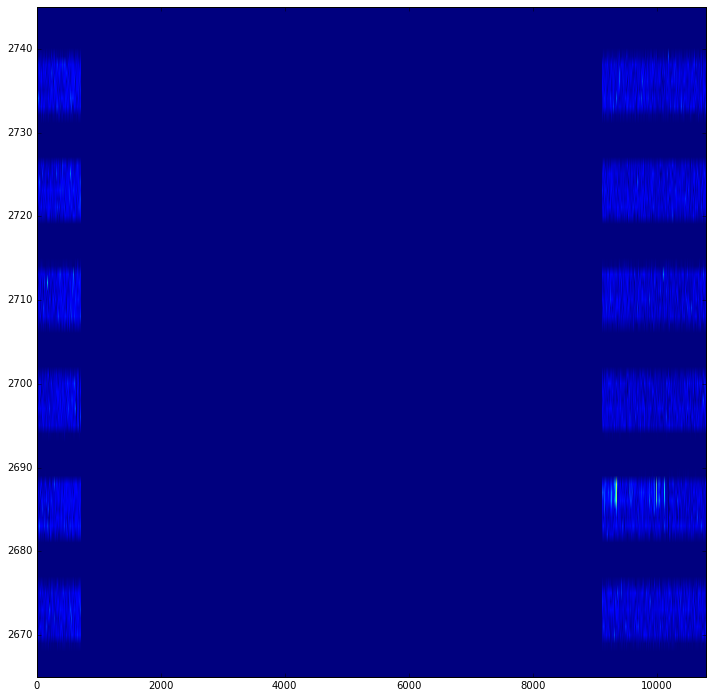

In [27]:
from astropy.io import fits
data = fits.getdata('foot.fits')

fig, ax = pl.subplots(figsize=(12,12))
im = ax.imshow(data, aspect='auto')
#ax.set_xlim([0,750])
ax.set_ylim([2665,2745])